In [1]:
import os
import pathlib
import pickle

import numpy as np
import scipy.stats as stats
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Loader:
    def __init__(self, occ, noise, ind, img_num):
        self.occ = occ
        self.noise = noise
        self.img_num = img_num
        self.ind = ind
        
        def gen_path(occ, noise, ind, img_num):
            P_path = os.path.join("PR_test", occ, noise, ind, str(img_num)+"_pre.pickle")
            R_path = os.path.join("PR_test", occ, noise, ind, str(img_num)+"_rec.pickle")
            occ_path = os.path.join("preprocessing", "labels", occ+"_l", noise, ind, ind+"_"+str(img_num)+"_occlusion.pickle")
            label_path = os.path.join("preprocessing", "labels", occ+"_l", noise, ind, ind+"_"+str(img_num)+"_label.pickle")
            return P_path, R_path, occ_path, label_path
        
        P_path, R_path, occ_path, label_path = gen_path(occ, noise, ind, img_num)
        with open(str(P_path), 'rb') as f:
            self.P = np.array(pickle.load(f))
        with open(str(R_path), 'rb') as f:
            self.R = np.array(pickle.load(f))
        with open(str(occ_path), 'rb') as f:
            self.occ = np.array(pickle.load(f))
        with open(str(label_path), 'rb') as f:
            self.label = np.array(pickle.load(f))

    def prop_occ(self):
        label_mode, _ = stats.mode(self.label, axis=0)
        label_mode = np.squeeze(label_mode).astype("int")
        self.occ = np.average(self.occ, axis=0)[label_mode]
        
    def prop_PR(self):
        if self.img_num == 32:
            sup_thes = list(range(4,33))[::-1]
        if self.img_num == 64:
            sup_thes = list(range(8,65))[::-2]
        if self.img_num == 128:
            sup_thes = list(range(16,129))[::-4]
        
        global_true_idx = [np.where((self.P>0.99)[:,i])[0]
                           if np.where((self.P>0.99)[:,i])[0].size != 0 
                           else np.array([-1])
                           for i in range(self.P.shape[1])]
        self.global_true_idx = global_true_idx
        local_opt_idx = [np.argmax(self.R[:,i][global_true_idx[i]]) for i in range(len(global_true_idx))]
        global_opt_idx = [g_idx[l_idx] for g_idx, l_idx in zip(global_true_idx, local_opt_idx)]
        self.local_opt_idx = local_opt_idx
        self.global_opt_idx = global_opt_idx
        
        self.opt_sup_th = [sup_thes[opt_idx] for opt_idx in global_opt_idx]
        


In [3]:
occs = ["q_a", "q_aothin", "q_aothick"]
noises = ["0mm", "1mm", "3mm"]
inds = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]

In [4]:
l = []
for noise in noises:
    for img_num in img_nums:
        temp_occ_val_list = []
        temp_opt_sup_th_list = []
        for occ in occs:
            for ind in inds:
                lo = Loader(occ, noise, ind, img_num)
                lo.prop_occ()
                lo.prop_PR()
                for occ_val, sup_th in zip(lo.occ, lo.opt_sup_th):
                    temp_l = [noise, img_num, occ_val, sup_th/img_num, occ]
                    l.append(temp_l)
l = np.array(l)

In [5]:
def dataset_discriminater(dataset):
    if dataset == "q_a":
        return "No pillars"
    elif dataset == "q_aothin":
        return "Thin pillars"
    else:
        return "Thick pillars"

In [6]:
dataset_list = [dataset_discriminater(dataset) for dataset in l[:,4]]

In [7]:
df = pd.DataFrame({
    'Noise' : l[:,0],
    'Image Number' : l[:,1].astype("int"),
    'Occlusion index' : 1-l[:,2].astype("float"),
    'Optimal Support \nthreshold': l[:,3].astype("float"),
    'Dataset' : dataset_list,
    })

In [8]:
df

,Noise,Image Number,Occlusion index,Optimal Support \nthreshold,Dataset
0,0mm,128,0.720340,0.84375,No pillars
1,0mm,128,0.725404,0.96875,No pillars
2,0mm,128,0.735415,0.84375,No pillars
3,0mm,128,0.749982,0.90625,No pillars
4,0mm,128,0.723378,0.93750,No pillars
...,...,...,...,...,...
643,3mm,32,0.780024,0.46875,Thick pillars
644,3mm,32,0.767003,0.53125,Thick pillars
645,3mm,32,0.864886,0.43750,Thick pillars
646,3mm,32,0.839831,0.12500,Thick pillars


In [9]:
df.to_csv('sim.csv')

In [10]:
e_df = df[(df["Noise"] == "0mm") & (df["Image Number"] == 128)]

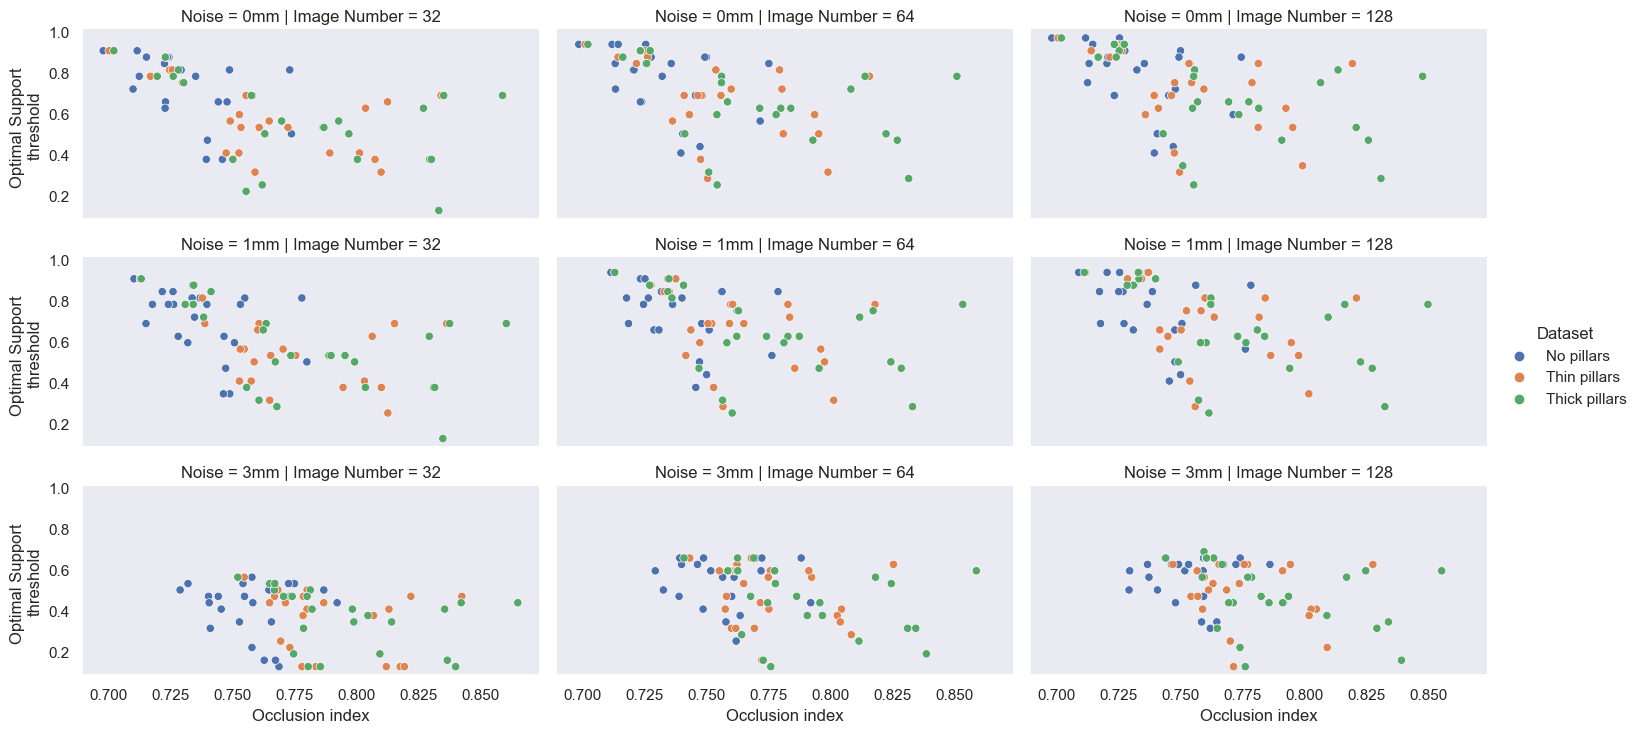

In [11]:
sns.set_theme(style="dark")

g = sns.relplot(
    data=df, kind="scatter",
    x="Occlusion index", y="Optimal Support \nthreshold", col="Image Number", row="Noise",
    hue="Dataset",
    height=2.5, aspect=2, legend=True,
)

In [12]:
e_df = df[(df["Noise"] == "0mm") & (df["Image Number"] == 128)]

#lr = LinearRegression()

X = e_df[["Occlusion index"]].values
y = e_df["Optimal Support \nthreshold"].values

#lr.fit(X, Y)
X_plot = np.linspace(0.65, 0.9, 100)
X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))

In [13]:
brr_poly = make_pipeline(
    BayesianRidge(),
).fit(X, y)

y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)

array([0.80999277, 0.79623184, 0.76902674, 0.72944407, 0.80173696,
       0.7903808 , 0.74237449, 0.75494243, 0.83117863, 0.87036783,
       0.80128675, 0.6718612 , 0.83333638, 0.77716372, 0.7351114 ,
       0.80196265, 0.80883566, 0.82547704, 0.82950204, 0.73113362,
       0.79945791, 0.66297837, 0.73741389, 0.75815196, 0.71724823,
       0.79661679, 0.70386752, 0.71915993, 0.79364253, 0.6442392 ,
       0.6065874 , 0.73622935, 0.75831743, 0.86340193, 0.75360681,
       0.64443281, 0.80680197, 0.65116646, 0.61407512, 0.7678704 ,
       0.7358123 , 0.8272752 , 0.7392522 , 0.72024138, 0.8010744 ,
       0.54130052, 0.5958429 , 0.73044078, 0.65466358, 0.79102192,
       0.64382627, 0.71398936, 0.79659612, 0.55701628, 0.52379846,
       0.72699113, 0.71071534, 0.85986888, 0.71630278, 0.61858513,
       0.79984906, 0.57616046, 0.5371637 , 0.74844562, 0.67677566,
       0.81954468, 0.66560471, 0.71501898, 0.8019485 , 0.46447202,
       0.51002714, 0.71501152, 1.00113699, 0.9942748 , 0.98741

In [14]:
e_df

,Noise,Image Number,Occlusion index,Optimal Support \nthreshold,Dataset
0,0mm,128,0.720340,0.84375,No pillars
1,0mm,128,0.725404,0.96875,No pillars
2,0mm,128,0.735415,0.84375,No pillars
3,0mm,128,0.749982,0.90625,No pillars
4,0mm,128,0.723378,0.93750,No pillars
...,...,...,...,...,...
67,0mm,128,0.755290,0.78125,Thick pillars
68,0mm,128,0.723300,0.93750,Thick pillars
69,0mm,128,0.847490,0.78125,Thick pillars
70,0mm,128,0.830726,0.28125,Thick pillars


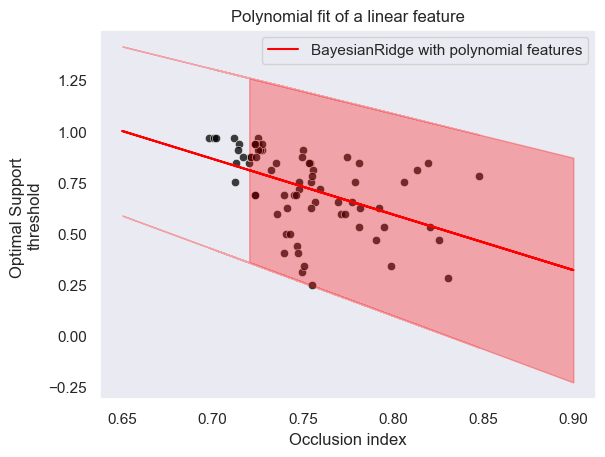

In [29]:
ax = sns.scatterplot(
    data=e_df, x="Occlusion index", y="Optimal Support \nthreshold", color="black", alpha=0.75
)

ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")


ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a linear feature")

In [43]:
x1 = X_plot.ravel()[len(X_plot)-100:][0]
x2 = X_plot.ravel()[len(X_plot)-100:][-1]

In [44]:
x2

0.9

In [46]:
y1 = (y_brr)[len(X_plot)-100:][0] - y_brr_std[len(X_plot)-100:][0]*(1/2)
y2 = (y_brr)[len(X_plot)-100:][-1] - y_brr_std[len(X_plot)-100:][-1]*(1/2)

In [47]:
y1

0.794479899217521

In [48]:
y2

0.047270199520606515

In [38]:
with open('bottom_sup_th_para.pickle', 'rb') as f:
    a = pickle.load(f)

In [39]:
a

[-2.988838798787658, 2.7372251184294987]

In [49]:
a = (y2-y1)/(x2-x1)
b = y1 - a*x1
para_vector = np.array((a,b))

In [50]:
a

-2.988838798787658

In [51]:
b

2.7372251184294987

In [37]:
with open('upper_sup_th_para.pickle', 'wb') as f:
    pickle.dump([a, b], f)

In [17]:
dataset_name = "exp2021_005_GmJMC112_01_MVI_01"
real_label_path = "../real_data/labels/{}_label.pickle".format(dataset_name)
real_occ_path = "../real_data/labels/{}_occlusion.pickle".format(dataset_name)

with open(real_label_path, 'rb') as f:
    real_label = np.array(pickle.load(f))
    
with open(real_occ_path, 'rb') as f:
    real_occ = np.array(pickle.load(f))

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [19]:
selected_cam = np.load('../real_data/view_mats/{}_camera_select.npy'.format(dataset_name))

In [26]:
real_leaf_idx = np.where(np.average(np.array(real_occ)[selected_cam], axis=0) > 0.05)[0]

In [27]:
X = 1 - np.average(real_occ, axis=0)[real_leaf_idx]

In [28]:
opt_th=para_vector@np.stack((X,np.ones(len(X))), axis=0)*128

In [29]:
print("leaf_idx:", real_leaf_idx)
print("predicted_opt_support:", np.round(opt_th))

leaf_idx: [  9  14  16  18  30  42  45  46  49  62  71  87  89  95 114 140]
predicted_opt_support: [14. 27. 32.  5. 30. 19. 14. 16.  9. 35. 40. 44. 24. 20. 37. 27.]


In [ ]:
opt_sups = [(31, 55), (33, 50), (34, 40), (35, 60), (37,55), (38, 45), (45, 50)]